In [ ]:
#!kaggle datasets download -d denislukovnikov/ffhq256-images-only
#!cd $STORE_DIR/Datasets
#!unzip ffhq256-images-only.zip -d ffhq256

In [1]:
# extract features with vae 
# train a diffusion model on the features
# DiT? PixArt?

In [2]:
ffhq256dir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/ffhq256 "

In [16]:
import matplotlib.pyplot as plt
from os.path import join
from PIL import Image
import numpy as np
import torch
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image


In [ ]:

import sys
import os
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet

from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid


def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device


class EDMCNNPrecondWrapper(nn.Module):
    def __init__(self, model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0):
        super().__init__()
        self.model = model
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        
    def forward(self, X, sigma, cond=None, ):
        sigma[sigma == 0] = self.sigma_min
        ## edm preconditioning for input and output
        ## https://github.com/NVlabs/edm/blob/main/training/networks.py#L632
        # unsqueze sigma to have same dimension as X (which may have 2-4 dim) 
        sigma_vec = sigma.view([-1, ] + [1, ] * (X.ndim - 1))
        c_skip = self.sigma_data ** 2 / (sigma_vec ** 2 + self.sigma_data ** 2)
        c_out = sigma_vec * self.sigma_data / (sigma_vec ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma_vec ** 2).sqrt()
        c_noise = sigma.log() / 4
        model_out = self.model(c_in * X, c_noise.view(-1), cond=cond) # this is required for EDM Unet model. 
        return c_skip * X + c_out * model_out


def create_unet_model(config):
    unet = SongUNet(in_channels=config.channels, 
                out_channels=config.channels, 
                num_blocks=config.layers_per_block, 
                attn_resolutions=config.attn_resolutions, 
                decoder_init_attn=config.decoder_init_attn if 'decoder_init_attn' in config else True,
                model_channels=config.model_channels, 
                channel_mult=config.channel_mult, 
                dropout=config.dropout, 
                img_resolution=config.img_size, 
                label_dim=config.label_dim,
                embedding_type='positional', 
                encoder_type='standard', 
                decoder_type='standard', 
                augment_dim=config.augment_dim, #  no augmentation , 9 for defaults. 
                channel_mult_noise=1, 
                resample_filter=[1,1], 
                )
    pytorch_total_grad_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    print(f'total number of trainable parameters in the Score Model: {pytorch_total_grad_params}')
    pytorch_total_params = sum(p.numel() for p in unet.parameters())
    print(f'total number of parameters in the Score Model: {pytorch_total_params}')
    return unet

In [22]:

from pprint import pprint
import argparse
from typing import List, Tuple
def generate_record_times(ranges: List[Tuple[int, int, int]]) -> List[int]:
    """
    Generates a list of record times based on the provided ranges.

    Args:
        ranges (List[Tuple[int, int, int]]): List of ranges defined by (start, end, step).

    Returns:
        List[int]: Generated record times.
    """
    record_times = []
    for start, end, step in ranges:
        record_times.extend(range(start, end, step))
    return record_times

In [9]:
import sys
sys.path.append("/n/home12/binxuwang/Github/edm")
from training.dataset import TensorDataset, ImageFolderDataset

edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
ffhq64_dataset = ImageFolderDataset(edm_ffhq64_path)
ffhq64_Xtsr = torch.stack([torch.from_numpy(ffhq64_dataset[i][0]) for i in range(len(ffhq64_dataset))])


In [24]:
layers_per_block = 1
decoder_init_attn = True
attn_resolutions = [8, 16,]
model_channels = 128
channel_mult = [1, 2, 4, 4]
batch_size = 512
img_size = 64
nsteps = 10000
lr = 1e-4
record_frequency = 100
exp_name = "ffhq64_edm_model_pilot"
eval_sample_size = 5000

ranges = [(0, 10, 1), (10, 50, 2), (50, 100, 4), (100, 500, 8), (500, 2500, 16), (2500, 5000, 32), (5000, 10000, 64)]
record_times = generate_record_times(ranges)

saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
savedir = f"{saveroot}/{exp_name}"
os.makedirs(savedir, exist_ok=True)

In [25]:
sample_store = {}
loss_store = {}

eval_batch_size = 1024 # Process in batches of 1000
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    x_out_batches = []
    for i in range(0, eval_sample_size, eval_batch_size):
        batch_size_i = min(eval_batch_size, eval_sample_size - i)
        noise_init = torch.randn(batch_size_i, *imgshape).to(device)
        x_out_i, x_traj_i, x0hat_traj_i, t_steps_i = edm_sampler(model, noise_init,
                        num_steps=35, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
        x_out_batches.append(x_out_i)
    
    x_out = torch.cat(x_out_batches, dim=0)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

device = get_device()
Xtsr = (ffhq64_Xtsr.to(device) - 0.5) / 0.5
pnts = Xtsr.view(Xtsr.shape[0], -1)
imgshape = Xtsr.shape[1:]
ndim = pnts.shape[1]
# cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
config = edict(
    channels=3,
    img_size=img_size,
    layers_per_block=layers_per_block,
    decoder_init_attn=decoder_init_attn,
    attn_resolutions=attn_resolutions,
    model_channels=model_channels,
    channel_mult=channel_mult,
    dropout=0.0,
    label_dim=0,
    augment_dim=0,
)
pprint(config)

json.dump(config, open(f"{savedir}/config.json", "w"))
unet = create_unet_model(config)
model_precd = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(Xtsr, model_precd, edm_loss_fn, 
                                    lr=lr, nepochs=nsteps, batch_size=batch_size, device=device, 
                                    callback=sampling_callback_fn, callback_freq=record_frequency, callback_step_list=record_times)


pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")

MNIST dataset 70000 samples, 12288 features
{'attn_resolutions': [8, 16],
 'augment_dim': 0,
 'channel_mult': [1, 2, 4, 4],
 'channels': 3,
 'decoder_init_attn': True,
 'dropout': 0.0,
 'img_size': 64,
 'label_dim': 0,
 'layers_per_block': 1,
 'model_channels': 128}
total number of trainable parameters in the Score Model: 80580867
total number of parameters in the Score Model: 80580867


  0%|          | 0/10000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 

: 

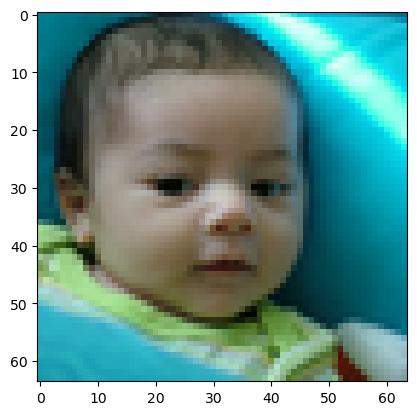

In [15]:
plt.imshow(ffhq64_dataset[0][0].transpose(1, 2, 0))
plt.show()

In [6]:
# load from .zip file, no need to unzip, load into memory
from torchvision.io import read_image
import torch

# Load the first image from the zip file
image = read_image(edm_ffhq64_path)




RuntimeError: Unsupported image file. Only jpeg and png are currently supported.